<a href="https://colab.research.google.com/github/sakshisubedi/CSE_256_NLP/blob/main/fewshot/imdb_fewshot_setfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CSE_256_Project

/content/drive/MyDrive/CSE_256_Project


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from datasets import Dataset


In [ ]:
# Install required packages
!pip install sentence_transformers
!pip install setfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import required packages
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('IMDB-Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# prepare data for setfit api
data = data.rename(columns={'review':'text','sentiment':'label_text'})
data['label'] = data['label_text'].apply(lambda x : 1 if x=='positive' else 0)

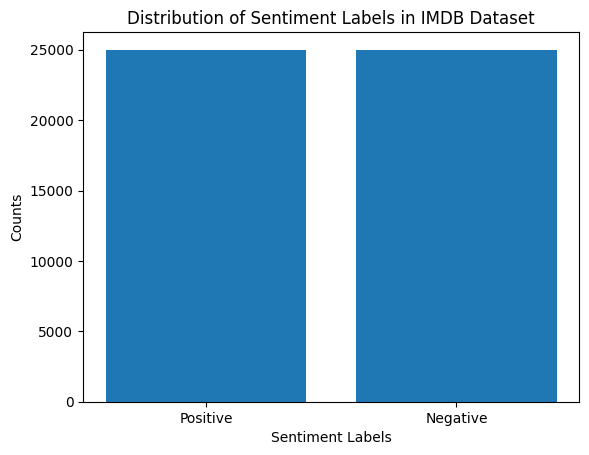

In [ ]:
positive_count = sum(1 for label in data['label'] if label == 1)
negative_count = len(data['label']) - positive_count
labels = ['Positive', 'Negative']
counts = [positive_count, negative_count]
# Plot the bar plot
plt.bar(labels, counts)
plt.xlabel('Sentiment Labels')
plt.ylabel('Counts')
plt.title('Distribution of Sentiment Labels in IMDB Dataset')
plt.show()

In [ ]:
# train test split
data_train = Dataset.from_pandas( data.iloc[:50,:])
data_eval =  Dataset.from_pandas(data.iloc[50:100,:])

In [ ]:
# loading model
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
batch_size = 8
learning_rate = 2e-05
num_iterations=40
num_epochs=1

In [ ]:
# Create trainer
trainer = SetFitTrainer(
    model = model,
    train_dataset = data_train,
    eval_dataset = data_eval,
    loss_class = CosineSimilarityLoss,
    batch_size = batch_size,
    learning_rate = learning_rate,
    num_iterations = num_iterations,
    num_epochs = num_epochs
)

In [ ]:
import time

# Start the timer
start_time = time.time()

In [ ]:
 # Fine-tune the model on downstream task for 10 epochs
trainer.train()

Generating Training Pairs:   0%|          | 0/40 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 4000
  Num epochs = 1
  Total optimization steps = 500
  Total train batch size = 8


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
execution_time = time.time() - start_time
execution_time

723.1492989063263

In [ ]:
# Evaluate model performance on evaluation dataset
performance = trainer.evaluate()
print(performance)

***** Running evaluation *****


{'accuracy': 0.98}


In [ ]:
test_pred = trainer.model.predict(data_eval['text'])

Text(0.5, 1.0, 'Confusion Matrix')

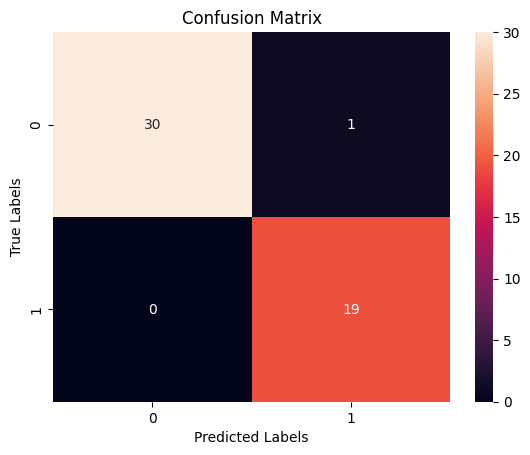

In [ ]:
confusion_mat = confusion_matrix(data_eval['label'], test_pred)
sns.heatmap(confusion_mat, annot=True)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

In [ ]:
# Calculate class-wise accuracy
import numpy as np
class_accuracy = np.diagonal(confusion_mat) / np.sum(confusion_mat, axis=1)
print("class-wise accuracy")
class_accuracy

class-wise accuracy


array([0.96774194, 1.        ])

In [ ]:
# Identify misclassified instances
num_classes = len(confusion_mat)

misclassified_instances = []

for i in range(num_classes):
    for j in range(num_classes):
        if i != j and confusion_mat[i, j] > 0:
            misclassified_instances.append((i, j, confusion_mat[i, j]))
misclassified_instances

[(0, 1, 1)]

In [ ]:
data_eval

Dataset({
    features: ['text', 'label_text', 'label'],
    num_rows: 50
})

In [ ]:
# printing misclassified data
wrong_predictions = 0
for idx, _ in enumerate(test_pred):
  if data_eval['label'][idx] != test_pred[idx]:
    print(data_eval['text'][idx] + "\n\n")
    wrong_predictions += 1

This is a typical Steele novel production in that two people who have undergone some sort of tragedy manage to get together despite the odds. I wouldn't call this a spoiler because anyone who has read a Steele novel knows how they ALL end. If you don't want to know much about the plot, don't keep reading.<br /><br />Gilbert's character, Ophelia, is a woman of French decent who has lost her husband and son in an accident. Gilbert needs to stop doing films where she is required to have an accent because she, otherwise a good actress, cannot realistically pull off any kind of accent. Brad Johnson, also an excellent actor, is Matt, who is recovering from a rather nasty divorce. He is gentle, convincing and compelling in this role.<br /><br />The two meet on the beach through her daughter, Pip, and initially, Ophelia accuses Matt of being a child molester just because he talked art with the kid. All of them become friends after this episode and then the couple falls in love.<br /><br />The 

In [ ]:
# printing wrong predictions
wrong_predictions

1

In [ ]:
# common misclassification
common_misclassifications = sorted(misclassified_instances, key=lambda x: x[2], reverse=True)
common_misclassifications

[(0, 1, 1)]

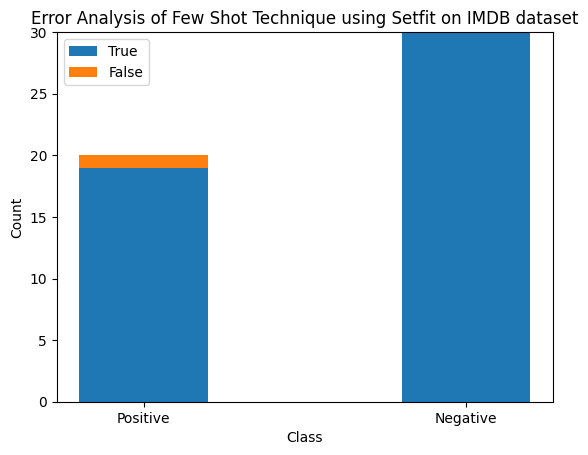

In [ ]:
true_positives = confusion_mat[1, 1]
true_negatives = confusion_mat[0, 0]
false_positives = confusion_mat[0, 1]
false_negatives = confusion_mat[1, 0]

# Set the labels for x-axis
labels = ['Positive', 'Negative']

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x, [true_positives, true_negatives], width, label='True')
rects2 = ax.bar(x, [false_positives, false_negatives], width, label='False', bottom=[true_positives, true_negatives])

# Set plot title, legend, and axis labels
ax.set_title('Error Analysis of Few Shot Technique using Setfit on IMDB dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()

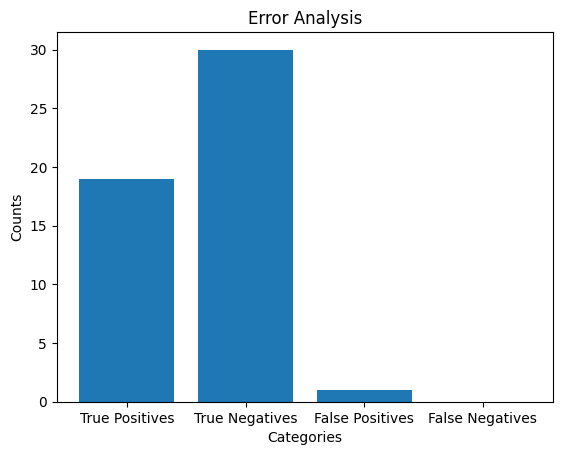

In [ ]:
categories = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']

# Define the counts for each category
counts = [true_positives, true_negatives, false_positives, false_negatives]

# Plot the error analysis results
plt.bar(categories, counts)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Error Analysis')
plt.show()